<a href="https://colab.research.google.com/github/ravikshaga/ERAV2/blob/main/S8/ERAV2_S8_LN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision

In [ ]:
print('==> Preparing data..')
batch_size = 32
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')



==> Preparing data..


100%|██████████| 170498071/170498071 [00:03<00:00, 56729104.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.2023, 1/0.1994, 1/0.2010 ]),
                                transforms.Normalize(mean = [ -0.4914, -0.4822, -0.4465 ],
                                                     std = [ 1., 1., 1. ]),
                               ])


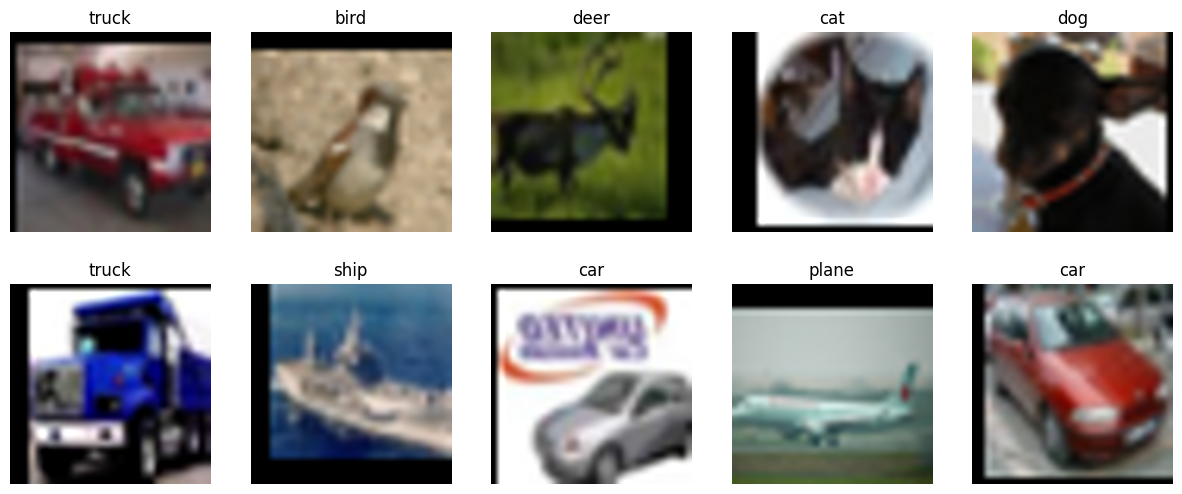

In [ ]:
curr_data = next(iter(trainloader))
cifar10_to_plot = curr_data[0][:10,:,:,:]
cifar10_to_plot_labels = curr_data[1]
# print(cifar10_to_plot_labels)
import matplotlib.pyplot as plt
#Visualizing CIFAR 10
fig, axes1 = plt.subplots(2,5,figsize=(15,6))
for r in range(2):
    for c in range(5):
        img =cifar10_to_plot[2*c+r]
        axes1[r][c].set_axis_off()
        axes1[r][c].title.set_text(classes[cifar10_to_plot_labels[2*c+r]])
        axes1[r][c].imshow(transforms.ToPILImage()(invTrans(img)), interpolation='spline16')

In [ ]:
# Make this network:
# C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11
# cN is 1x1 Layer
# Keep the parameter count less than 50000
# Max Epochs is 20

In [ ]:
dropout_value = 0.1
num_groups = 1  ### layer norm
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # C1, input size: 32, in_channels = 3, jin = 1
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 16),
            nn.Dropout(dropout_value)
        ) # out = 32 , jout = 1, rf = 3

        # C2, in = 32, jin = 1
        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),
            nn.Dropout(dropout_value)
        ) # out = 32 , jout = 1, rf = 5

        # c3, in = 32, jin = 1
        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 64),
            nn.Dropout(dropout_value)
        ) # out = 32, jout = 1, rf = 5

        # TRANSITION BLOCK, MaxPool P1
        self.P1 = nn.MaxPool2d(2, 2) # output_size = 16, jout = 2, rf = 6

        # C4, in = 16, jin = 2
        self.C4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 16),
            nn.Dropout(dropout_value)
        ) # out = 16, jout = 2, rf = 10

        # C5, in = 16, jin = 2
        self.C5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),
            nn.Dropout(dropout_value)
        ) # out = 16, jout = 2, rf = 14

        # C6, in = 16, jin = 2
        self.C6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),
            nn.Dropout(dropout_value)
        ) # out = 16, jout = 2, rf = 18

        # c7, in = 16, jin = 2
        self.c7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),
            nn.Dropout(dropout_value)
        ) # out = 16, jout = 2, rf = 18

        # TRANSITION BLOCK, MaxPool P2
        self.P2 = nn.MaxPool2d(2, 2) # output_size = 8, rf = 20

        # C8, in = 8, jin = 4
        self.C8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 16),
            nn.Dropout(dropout_value)
        ) # out = 8, jout = 4, rf = 28

        # C9, in = 8, jin = 4
        self.C9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),
            nn.Dropout(dropout_value)
        ) # out = 8, jout = 4, rf = 36

        # C10, in = 8, jin = 4
        self.C10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=28, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups, 28),
            nn.Dropout(dropout_value)
        ) # out = 8, jout = 4, rf = 44

        self.GAP = nn.Sequential(
            nn.AvgPool2d(kernel_size=8) # 7>> 9... nn.AdaptiveAvgPool((1, 1))
        ) # out = 1

        # c11, input size:
        self.c11 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU(),
            # nn.BatchNorm2d(10),
            # nn.Dropout(dropout_value)
        ) # out = , rf =

    def forward(self, x):
        x = self.C1(x)
        x = self.C2(x)
        x = self.c3(x)
        x = self.P1(x)
        x = self.C4(x)
        x = self.C5(x)
        x = self.C6(x)
        x = self.c7(x)
        x = self.P2(x)
        x = self.C8(x)
        x = self.C9(x)
        x = self.C10(x)
        x = self.GAP(x)
        x = self.c11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]           2,048
             ReLU-10           [-1, 64, 32, 32]               0
        GroupNorm-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
        MaxPool2d-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 16,

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    scheduler.step()
    test(model, device, testloader)

EPOCH: 0


Loss=2.099067211151123 Batch_id=1562 Accuracy=23.82: 100%|██████████| 1563/1563 [00:38<00:00, 40.75it/s]



Test set: Average loss: 1.8380, Accuracy: 3098/10000 (30.98%)

EPOCH: 1


Loss=1.947775959968567 Batch_id=1562 Accuracy=31.31: 100%|██████████| 1563/1563 [00:36<00:00, 43.03it/s]



Test set: Average loss: 1.7217, Accuracy: 3649/10000 (36.49%)

EPOCH: 2


Loss=1.4359005689620972 Batch_id=1562 Accuracy=35.20: 100%|██████████| 1563/1563 [00:36<00:00, 42.79it/s]



Test set: Average loss: 1.5920, Accuracy: 4080/10000 (40.80%)

EPOCH: 3


Loss=2.080132007598877 Batch_id=1562 Accuracy=39.38: 100%|██████████| 1563/1563 [00:37<00:00, 41.61it/s]



Test set: Average loss: 1.6040, Accuracy: 3962/10000 (39.62%)

EPOCH: 4


Loss=1.2432196140289307 Batch_id=1562 Accuracy=44.23: 100%|██████████| 1563/1563 [00:38<00:00, 40.76it/s]



Test set: Average loss: 1.4487, Accuracy: 4767/10000 (47.67%)

EPOCH: 5


Loss=1.3520030975341797 Batch_id=1562 Accuracy=48.56: 100%|██████████| 1563/1563 [00:37<00:00, 41.79it/s]



Test set: Average loss: 1.3175, Accuracy: 5184/10000 (51.84%)

EPOCH: 6


Loss=1.2466764450073242 Batch_id=1562 Accuracy=56.12: 100%|██████████| 1563/1563 [00:37<00:00, 41.40it/s]



Test set: Average loss: 1.1884, Accuracy: 5673/10000 (56.73%)

EPOCH: 7


Loss=1.0434623956680298 Batch_id=1562 Accuracy=57.22: 100%|██████████| 1563/1563 [00:38<00:00, 41.10it/s]



Test set: Average loss: 1.1551, Accuracy: 5818/10000 (58.18%)

EPOCH: 8


Loss=1.2471739053726196 Batch_id=1562 Accuracy=58.06: 100%|██████████| 1563/1563 [00:37<00:00, 41.42it/s]



Test set: Average loss: 1.1445, Accuracy: 5861/10000 (58.61%)

EPOCH: 9


Loss=0.9655051231384277 Batch_id=1562 Accuracy=58.72: 100%|██████████| 1563/1563 [00:38<00:00, 40.81it/s]



Test set: Average loss: 1.1563, Accuracy: 5849/10000 (58.49%)

EPOCH: 10


Loss=0.8304213881492615 Batch_id=1562 Accuracy=59.40: 100%|██████████| 1563/1563 [00:37<00:00, 41.28it/s]



Test set: Average loss: 1.1134, Accuracy: 5957/10000 (59.57%)

EPOCH: 11


Loss=1.3184447288513184 Batch_id=1562 Accuracy=60.05: 100%|██████████| 1563/1563 [00:38<00:00, 40.80it/s]



Test set: Average loss: 1.0892, Accuracy: 6077/10000 (60.77%)

EPOCH: 12


Loss=1.5936731100082397 Batch_id=1562 Accuracy=61.25: 100%|██████████| 1563/1563 [00:37<00:00, 41.31it/s]



Test set: Average loss: 1.0857, Accuracy: 6092/10000 (60.92%)

EPOCH: 13


Loss=0.75498366355896 Batch_id=1562 Accuracy=61.26: 100%|██████████| 1563/1563 [00:37<00:00, 41.57it/s]



Test set: Average loss: 1.0786, Accuracy: 6138/10000 (61.38%)

EPOCH: 14


Loss=0.6921311020851135 Batch_id=1562 Accuracy=61.63: 100%|██████████| 1563/1563 [00:37<00:00, 41.14it/s]



Test set: Average loss: 1.0843, Accuracy: 6127/10000 (61.27%)

EPOCH: 15


Loss=0.751505970954895 Batch_id=1562 Accuracy=61.39: 100%|██████████| 1563/1563 [00:37<00:00, 41.72it/s]



Test set: Average loss: 1.0842, Accuracy: 6135/10000 (61.35%)

EPOCH: 16


Loss=0.8756774663925171 Batch_id=1562 Accuracy=61.67: 100%|██████████| 1563/1563 [00:38<00:00, 40.60it/s]



Test set: Average loss: 1.0702, Accuracy: 6171/10000 (61.71%)

EPOCH: 17


Loss=1.5439503192901611 Batch_id=1562 Accuracy=62.00: 100%|██████████| 1563/1563 [00:37<00:00, 41.25it/s]



Test set: Average loss: 1.0852, Accuracy: 6131/10000 (61.31%)

EPOCH: 18


Loss=0.9884927868843079 Batch_id=1562 Accuracy=62.01: 100%|██████████| 1563/1563 [00:37<00:00, 41.30it/s]



Test set: Average loss: 1.0829, Accuracy: 6145/10000 (61.45%)

EPOCH: 19


Loss=0.9636152386665344 Batch_id=1562 Accuracy=62.00: 100%|██████████| 1563/1563 [00:37<00:00, 41.46it/s]



Test set: Average loss: 1.0795, Accuracy: 6136/10000 (61.36%)



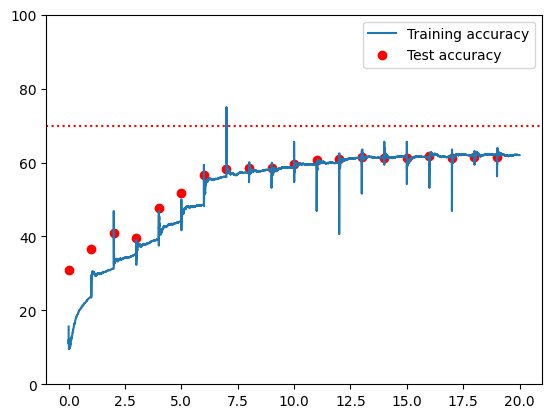

In [12]:
import numpy as np
n_batches = 1563

plt.plot(np.arange(len(train_acc))/n_batches, train_acc, label = 'Training accuracy')
plt.scatter(np.arange(len(test_acc)), test_acc, color = 'r', label = 'Test accuracy')
plt.legend()
plt.ylim([0,100])
plt.axhline(y = 70, color = 'r', linestyle = ':')
plt.show()


In [13]:
print('==> Preparing data..')
batch_size = 128

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=True, num_workers=2)



==> Preparing data..
Files already downloaded and verified


45


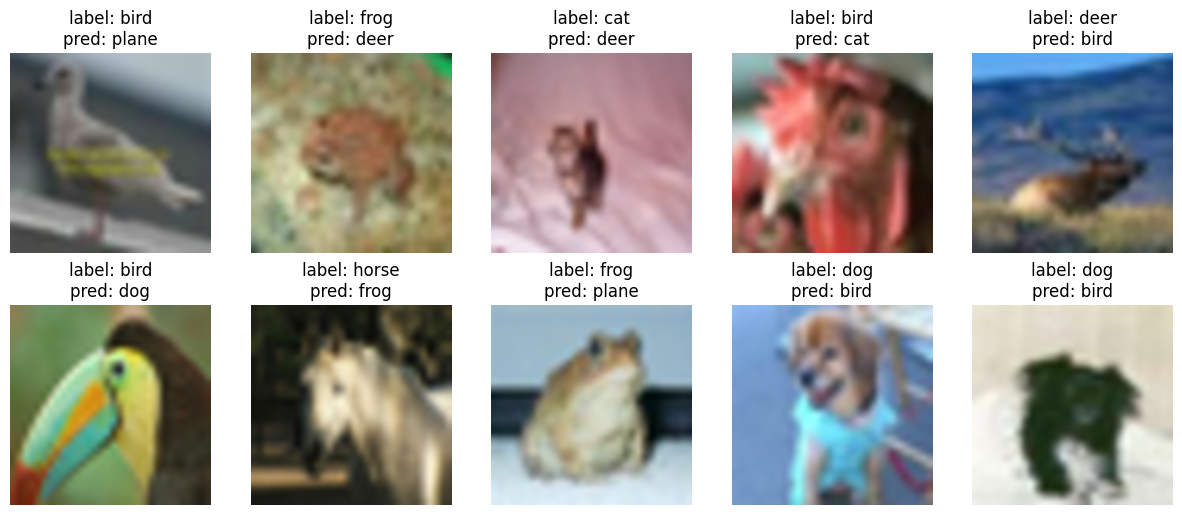

In [14]:

model.eval()
N_incorrect = 10
count = 0
with torch.no_grad():

    data, target = next(iter(testloader))
    data, target = data.to(device), target.to(device)
    output = model(data)
    # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    is_not_correct = pred.ne(target.view_as(pred))
    # print(is_not_correct)
    incorrect_pred_data = data[torch.squeeze(is_not_correct)]
    incorrect_pred_orig_labels = target[torch.squeeze(is_not_correct)]
    incorrect_pred_labels = torch.squeeze(pred[torch.squeeze(is_not_correct)])
    count += pred.ne(target.view_as(pred)).sum().item()
    print(count)



# print(pred.shape, target.shape, incorrect_pred_data.shape, incorrect_pred_orig_labels.shape, incorrect_pred_labels.shape)
cifar10_to_plot = incorrect_pred_data[:10,:,:,:]
cifar10_to_plot_orig_labels = incorrect_pred_orig_labels[:10]
cifar10_to_plot_pred_labels = incorrect_pred_labels[:10]
# print(cifar10_to_plot_labels)
import matplotlib.pyplot as plt
#Visualizing CIFAR 10
fig, axes1 = plt.subplots(2,5,figsize=(15,6))
for r in range(2):
    for c in range(5):
        img =cifar10_to_plot[2*c+r]
        axes1[r][c].set_axis_off()
        text = "label: " + str(classes[cifar10_to_plot_orig_labels[2*c+r]]) + '\n'
        text +=  "pred: " + str(classes[cifar10_to_plot_pred_labels[2*c+r]])
        axes1[r][c].title.set_text(text)
        axes1[r][c].imshow(transforms.ToPILImage()(invTrans(img)), interpolation='spline16')
